# Exploratory Data Analysis

## Initial Setup

### Import packages

In [238]:
import pandas as pd
import os
import sqlite3
import numpy as np
import matplotlib
import geopandas as gpd
from lets_plot.geo_data import *
from numerize import numerize as nz
import pyogrio
import fiona
from lets_plot import * # This imports all of ggplot2's functions
LetsPlot.setup_html() 

### Connect to the database

In [239]:
DATA_FOLDER_P = os.path.join('../data')
conn = sqlite3.connect(os.path.join(DATA_FOLDER_P, './home_prices.db'))


## Prepping

Read tables from db

In [240]:
zip_df = pd.read_sql_query("SELECT * FROM zip_info", conn)
# display(zip_df)
zillow_df = pd.read_sql_query("SELECT * FROM zillow", conn)
# display(zillow_df.info())

One error in user input, so fixing 02118. Also want to remove listings with price 0, as they are errors

In [241]:
zillow_df[zillow_df['addressZipcode'] == '2118'] = zillow_df[zillow_df['addressZipcode'] == '2118'].replace('2118', '02118')
zillow_df = zillow_df[zillow_df['price'] >0 ]
# display(zillow_df[zillow_df['addressZipcode'] == '02169'])

Setup function to aggregate data for box plot

In [242]:
#AI helped me on a previous assignment to create this function
agg_funcs = {
    'price': ['mean', 'median', 
                 ('25th', lambda x: np.percentile(x, 25)),  
                 ('75th', lambda x: np.percentile(x, 75)),  
                 'min', 'max', 'count']
}

Apply the functions and save as a price by zip code and price by broker df

In [243]:
price_zip = zillow_df.groupby('addressZipcode').agg(agg_funcs)
price_broker = zillow_df.groupby('brokerName').agg(agg_funcs)

In [244]:
#combining the two header lines onto one line
price_zip.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in price_zip.columns]
price_broker.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in price_broker.columns]
price_zip = price_zip.reset_index()
price_broker = price_broker.reset_index()

In [256]:
#AI helped beautify this plot
p = (ggplot(price_zip) + 
    geom_boxplot(aes(x='addressZipcode', ymin='price_min', lower='price_25th', middle='price_median', 
                     upper='price_75th', ymax='price_max'), stat='identity',
                     fill='red', color='black', alpha=0.5) +\
    scale_y_log2() 
    +labs(x='Zip Code', y='Price (log scale)')
    + theme_minimal2() 
    + scale_y_continuous(labels=['100k', '500k', '1M', '2.5M', '5M', '10M'], breaks=[100000, 500000, 1000000 , 2500000, 5000000, 10000000, 50000000])
    )
ggsave(p, 'zip_prices.svg', path='../docs/figures')
p.show()

In [246]:
#we only want to get brokers which deal with many houses(top 10 brokers)
price_broker = price_broker.sort_values(by='price_count', ascending=False)
price_broker['first_word'] = price_broker['brokerName'].str.split().str[0]
#shorten the names of the brokers for better readability
price_broker = price_broker.head(10)
        

In [255]:
#I used AI to beautify the chart 
g = (ggplot(price_broker) + 
    geom_boxplot(aes(x='first_word', ymin='price_min', lower='price_25th', middle='price_median', upper='price_75th', 
                     ymax='price_max'), stat='identity', fill='lightblue', color='black', alpha=0.7)
    + scale_y_log2() 
    + labs(x='Broker Name', y='Price (log scale)')
    + theme_minimal2() 
    + scale_y_continuous(labels=['100k', '500k', '1M', '2.5M', '5M', '10M'], breaks=[100000, 500000, 1000000 , 2500000, 5000000, 10000000, 50000000])
    )
ggsave(g, 'realtor.svg', path='../docs/figures')
g.show()


In [249]:
#same kind of deal as before, but we take only the data for vis purposes
gp = (ggplot(zillow_df.sample(frac=0.5)) + 
    geom_point(aes(x='area', y='price', color='addressZipcode'), stat='identity', alpha=0.7, size=2)
    + scale_y_log2() 
    + labs(x='Square Footage', y='Price (log scale)')
    + theme_minimal2() 
    + scale_y_continuous(labels=['100k', '500k', '1M', '2.5M', '5M', '10M'], breaks=[100000, 500000, 1000000 , 2500000, 5000000, 10000000, 50000000])
    )
ggsave(gp, 'sqft_price.svg', path='../docs/figures')
gp.show()

In [250]:
#this is to save the following matplotlib plots to svg (found online)
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
#path to the geojson file
GEO_JSON_PATH = '../data/ZIP_Codes.geojson'
gdf = gpd.read_file(GEO_JSON_PATH)

In [251]:
#make one large df with all the data we need by zip code
gdf_with_price = gdf.merge(price_zip, left_on='ZIP5', right_on='addressZipcode')
gdf_full = gdf_with_price.merge(zip_df, left_on='ZIP5', right_on='zip_code')
#calculate price compared to income
gdf_full['p_multiplier'] = gdf_full['price_median']/gdf_full['median_household_income']
#normalize the price for better display
gdf_full['price_norm'] = gdf_full['price_median'].apply(lambda x: x/1000000)

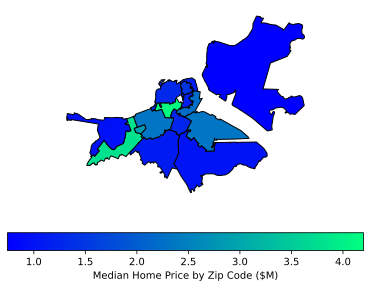

In [252]:
#had to use the matplotlib plot associated with GeoPandas df 
boston_median_home = gdf_full.plot(
  column='price_norm', cmap='winter', legend=True, 
  legend_kwds={"label": "Median Home Price by Zip Code ($M)", "orientation": "horizontal"},
  edgecolor='black', linewidth=1
)
#adjusting min y axis since lots of empty space
boston_median_home.set_ylim(42.32)
boston_median_home.set_axis_off()
#save the figure
boston_median_home.figure.savefig('../docs/figures/median_home_price.svg')

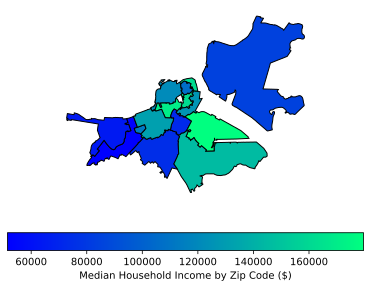

In [253]:
#pretty much the same function as before, but with different coloring
boston_median_income = gdf_full.plot(
  column='median_household_income', cmap='winter', legend=True, 
  legend_kwds={"label": "Median Household Income by Zip Code ($)", "orientation": "horizontal"},
  edgecolor='black', linewidth=1
)
boston_median_income.set_ylim(42.32)
boston_median_income.set_axis_off()
boston_median_income.figure.savefig('../docs/figures/median_income.svg')


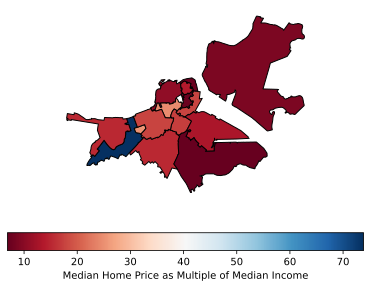

In [254]:
#pretty much the same function as before, but with different coloring
boston_multiplier = gdf_full.plot(
  column='p_multiplier', cmap='RdBu', legend=True, 
  legend_kwds={"label": "Median Home Price as Multiple of Median Income", "orientation": "horizontal"},
  edgecolor='black', linewidth=1
)
boston_multiplier.set_ylim(42.32)
boston_multiplier.set_axis_off()
boston_multiplier.figure.savefig('../docs/figures/home_multiplier.svg')